# Koncept drift analýza v metabolomické predikci při chladových stresových podmínkách u rostlin

## Instalace a import knihoven

In [260]:
!pip install scikit-learn
!pip install numpy scipy scikit-learn
!pip install scikit-multiflow

In [261]:
# Zpracování dat
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import deque
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import openpyxl  # Přidaný import pro čtení Excel souborů

# Validace, trénování a testování modelu
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

# Modely
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Detekce driftu
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import EDDM

# Korekce koncept driftu
from skmultiflow.drift_detection import ADWIN

# Metriky
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Načtení dat

Použité datasety jsou ze studie Weiszmann a spol.

WEISZMANN, Jakob; WALTHER, Dirk; CLAUW, Pieter; BACK, Georg; GUNIS, Joanna; REICHARDT, Ilka; KOEMEDA, Stefanie; JEZ, Jakub; NORDBORG, Magnus; SCHWARZEROVA, Jana; PIERIDES, Iro; NÄGELE, Thomas; WECKWERTH, Wolfram. Metabolome plasticity in 241 Arabidopsis thaliana accessions reveals evolutionary cold adaptation processes. Plant Physiology. 2023, roč. 193, č. 2, s. 980–1000. Dostupné z doi: 10.1093/plphys/kiad298

In [ ]:
# Načtení dat
#
# Data koncentrací měřena při 6 °C ze studie Weiszmann et al.
file_6_degree_c = "Metabolites_Ath_6C.xlsx"
# Data koncentrací měřena při 16 °C ze studie Weiszmann et al.
file_16_degree_c = "Metabolites_Ath_16C.xlsx"
# Data relativní růstové rychlosti (relative growth rate - rgr) měřena při 6 °C ze studie Weiszmann et al.
file_6_degree_rgr = "Phenotype_Ath_RGR_6.xlsx"
# Data relativní růstové rychlosti (relative growth rate - rgr) měřena při 16 °C ze studie Weiszmann et al.
file_16_degree_rgr = "Phenotype_Ath_RGR_16.xlsx"


In [262]:
data_6_degree_c = pd.read_excel(file_6_degree_c, header=None)
data_16_degree_c = pd.read_excel(file_16_degree_c, header=None)

output_data_6_degree_rgr = pd.read_excel(file_6_degree_rgr, header=None)
output_data_16_degree_rgr = pd.read_excel(file_16_degree_rgr, header=None)

## Rozdělení dat

In [263]:
# Vytvoření kopií původních dat
original_data_6_degree_c = data_6_degree_c.copy()
original_data_16_degree_c = data_16_degree_c.copy()

# Extrakce názvů ekotypů
names_of_ecotypes = original_data_6_degree_c.iloc[1:, 0].astype(str).apply(lambda x: x.split(',')[0]).tolist()

# Extrakce názvů metabolitů
names_of_metabolites = original_data_6_degree_c.iloc[0, 0].split(',')[1:]

# Definice cukrů
sugars = {'Maltose', 'Fructose', 'Galactose', 'Glucose'}

def extract_data(data, col=0):
    """
    Extrahuje číselná data z řetězce CSV.
    
    Parametry:
        data: Vstupní data
        sloupec: Index sloupce pro zpracování (výchozí: 0)
    
    Návratová hodnota:
        numpy.ndarray: Přetvarované pole extrahovaných číselných hodnot
    """
    column_data = data.iloc[1:, col]  # Přeskočení hlavičkového řádku
    split_rows = column_data.str.split(',')
    values = []

    for row in split_rows:
        for val in row[1:]:
            number = float(val.strip())
            values.append(number)
    return np.array(values).reshape(-1, len(row) - 1)


# Extrakce číselných dat pro koncentrace metabolitů a výstupní data
extract_6_degree_c = extract_data(original_data_6_degree_c)
extract_output_6_degree_rgr = extract_data(output_data_6_degree_rgr)
extract_16_degree_c = extract_data(original_data_16_degree_c)
extract_output_16_degree_rgr = extract_data(output_data_16_degree_rgr)


# Identifikace indexů cukrů a zbytku metabolitů
sugar_indices = []
metabolites_33 = []
non_sugar_indices = []
metabolites_sugar = []

for index, metabolite in enumerate(names_of_metabolites):
    if metabolite in sugars:
        sugar_indices.append(index)
        metabolites_sugar.append(metabolite)
    else:
        non_sugar_indices.append(index)
        metabolites_33.append(metabolite)

# Odstranění sloupců s cukry pro získání 33 metabolitů
data_33_6 = np.delete(extract_6_degree_c.copy(), sugar_indices, axis=1)
data_33_16 = np.delete(extract_16_degree_c.copy(), sugar_indices, axis=1)

# Extrakce dat cukrů zvlášť
data_sugar_6 = extract_6_degree_c.copy()[:, sugar_indices]
data_sugar_16 = extract_16_degree_c.copy()[:, sugar_indices]

# Vstupní a výstupní data pro 6 °C pouze pro 33 metabolitů (bez 4 sacharidů)
c_6_degree = data_33_6.copy()
rgr_6_degree = extract_output_6_degree_rgr.ravel()

# Vstupní a výstupní data pro 16°C pouze pro 33 metabolitů (bez 4 sacharidů)
c_16_degree = data_33_16.copy()
rgr_16_degree = extract_output_16_degree_rgr.ravel()

# Názvy ekotypů pro 6 °C a 16 °C
names_6_degree = np.array(names_of_ecotypes)
names_16_degree = np.array(names_of_ecotypes)

# Kombinace dat pro 6 °C a 16 °C
c_combined = np.vstack((c_6_degree, c_16_degree))
rgr_combined = np.concatenate((rgr_6_degree, rgr_16_degree))
names_combined = np.concatenate((names_6_degree, names_16_degree))
data_sugar_com = np.concatenate((data_sugar_6, data_sugar_16))

# Inicializace modelů
model_rf = RandomForestRegressor(n_estimators=100)
model_lr = LinearRegression()
model_svr = SVR(kernel='rbf')

# Ukládání modelů do slovníku pro snadné vyhledávání
models = {
    "Random Forest Regressor": model_rf,
    "Linear Regression": model_lr,
    "Support Vector Regression": model_svr,
}

## Vizualizace boxplotů

Text(0.5, 0, 'Koncentrace')

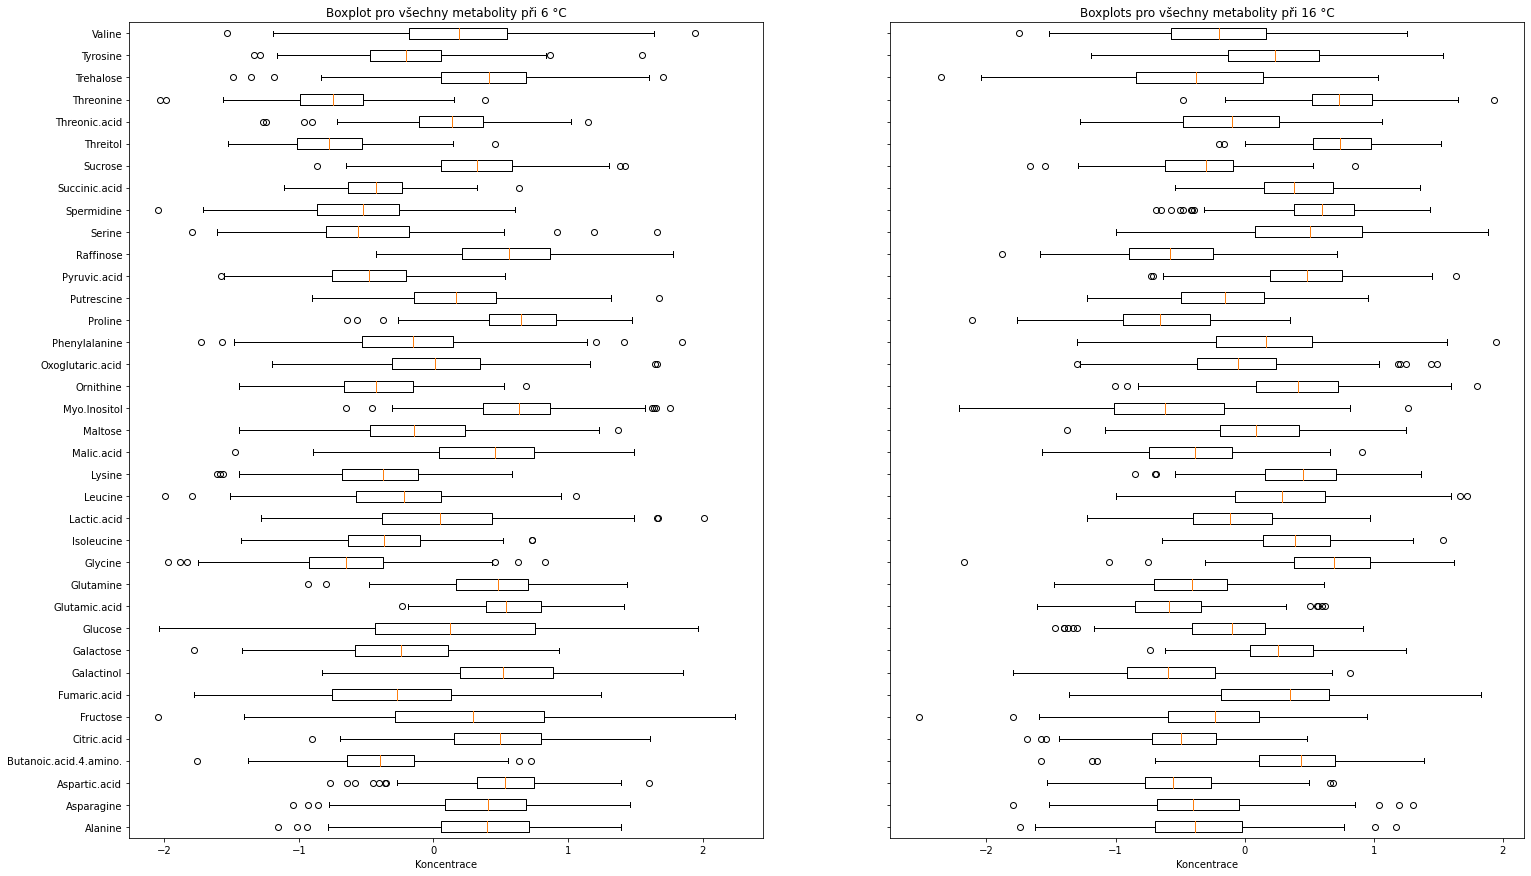

In [264]:
# Vytvoření dvou podgrafů vedle sebe
fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)  

# Boxplot pro 6 °C
axes[0].boxplot(extract_6_degree_c, vert=False)
axes[0].set_title('Boxplot pro všechny metabolity při 6 °C')
axes[0].set_yticks(range(1, len(names_of_metabolites) + 1))
axes[0].set_yticklabels(names_of_metabolites)
axes[0].set_xlabel('Koncentrace')

# Boxplot pro 16 °C
axes[1].boxplot(extract_16_degree_c, vert=False)
axes[1].set_title('Boxplots pro všechny metabolity při 16 °C')
axes[1].set_yticks(range(1, len(names_of_metabolites) + 1))
axes[1].set_yticklabels(names_of_metabolites)
axes[1].set_xlabel('Koncentrace')


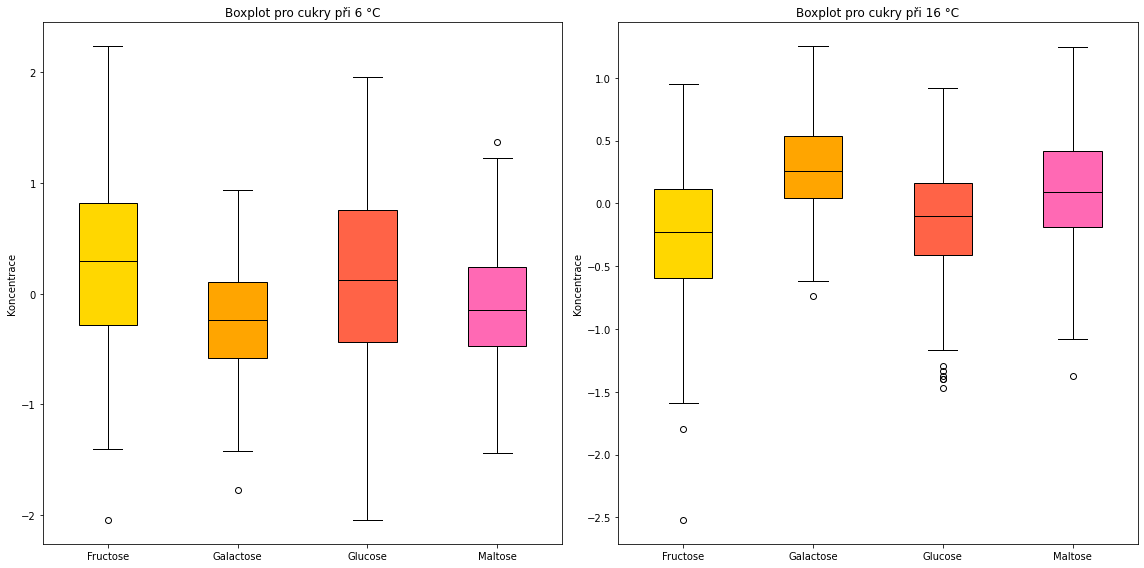

In [265]:
# Boxploty pro cukry
colors = ['#FFD700', '#FFA500', '#FF6347', '#FF69B4']

# Vytvoření figure a axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Funkce pro vykreslení barevného boxplotu
def colorful_boxplot(ax, data, title):
    bp = ax.boxplot(data, patch_artist=True)  # patch_artist=True umožní barvení boxů
    
    # Nastavení barvy boxů
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1)

# Boxplot pro 6 °C
colorful_boxplot(axes[0], data_sugar_6, 'Cukry při 6 °C')
axes[0].set_title('Boxplot pro cukry při 6 °C')
axes[0].set_xticks(range(1, len(metabolites_sugar) + 1))
axes[0].set_xticklabels(metabolites_sugar)
axes[0].set_ylabel('Koncentrace')

# Boxplot pro 16 °C
colorful_boxplot(axes[1], data_sugar_16, 'Cukry při 16 °C')
axes[1].set_title('Boxplot pro cukry při 16 °C')
axes[1].set_ylabel('Koncentrace')
axes[1].set_xticks(range(1, len(metabolites_sugar) + 1))
axes[1].set_xticklabels(metabolites_sugar)
plt.tight_layout()
#plt.savefig('boxplot_sugars.png', dpi=300, transparent=True)
plt.show()

## Rozdělení na trénovací a testovací sadu

In [266]:
# Rozdělení na trénovací a testovací sadu
# Pro 6°C
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(
    c_6_degree,
    rgr_6_degree,
    test_size=0.2
)

# Pro 16°C
X_train_16, X_test_16, y_train_16, y_test_16 = train_test_split(
    c_16_degree,
    rgr_16_degree,
    test_size=0.2
)

# Pro kombinovaná data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    c_combined,
    rgr_combined,
    test_size=0.2
)

## Hodnocení modelu

In [280]:
def evaluate_model(prediction, y):
    """
    Vyhodnotí výkon modelu pomocí různých metrik.

    Parametry:
        prediction: Predikované hodnoty z modelu.
        y: Skutečné cílové hodnoty.

    Návratová hodnota:
        list: [accuracy, R², MAE, MSE, RMSE, SMAPE]
            - accuracy (float): Pearsonův korelační koeficient.
            - R² (float): Koeficient determinace.
            - MAE (float): Průměrná absolutní chyba.
            - MSE (float): Střední kvadratická chyba.
            - RMSE (float): Odmocnina střední kvadratické chyby.
            - SMAPE (float): Symetrická průměrná procentuální chyba.
    """
     # Výpočet metrik
    pearson_corr, _ = pearsonr(y, prediction)
    accuracy = pearson_corr
    r2 = r2_score(y, prediction)
    mae = mean_absolute_error(y, prediction)
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse)
    smape = np.mean(200 * np.abs(prediction - y) / (np.abs(prediction) + np.abs(y)))

    return [accuracy, r2, mae, mse, rmse, smape]

## Trénování a testování modelu

In [281]:
def train_test_model(models, X_train, X_test, y_train, y_test, dataset_name):
    
    """
    Trénuje a testuje klasifikační model.
    
    Parametry:
        model: Objekt klasifikačního modelu (např. RandomForestClassifier()).

        
    Návratová hodnota:
        Slovník s metrikami a natrénovaným modelem.
    """
    results = []
    all_preds = {}
    y_test_binary ={}
    
    for name, model in models.items():
        
        # Křížová validace (5-fold) na trénovací sadě
        cv_scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring='r2'
        )
        cv_r2_mean = np.mean(cv_scores)
        cv_r2_std = np.std(cv_scores)
        
        # Trénování modelu
        model.fit(X_train, y_train)

        # Predikce na testovacích datech
        y_pred_reg = model.predict(X_test)
    
        # Predikce na trenovacích datech - stabilnější prah
        y_pred_train = model.predict(X_train)
        
        # Binarizace podle mediánu
        median_threshold = np.median(y_pred_train)
        y_pred = (y_pred_reg > median_threshold).astype(int)
        y_test_bin = (y_test > median_threshold).astype(int)
    
        # Uložení predikcí podle jména modelu
        all_preds[name] = y_pred
        y_test_binary[name] = y_test_bin
        
        # Vyhodnocení
        metrics = evaluate_model(y_pred_reg, y_test)
        results.append([name] + metrics + [cv_r2_mean, cv_r2_std])
    
    # Vytvoření DataFrame s výsledky vyhodnocení
    df_results = pd.DataFrame(
        results,
        columns=[
            "Model", 
            "Accuracy", 
            "R²", 
            "MAE", 
            "MSE", 
            "RMSE", 
            "SMAPE", 
            "CV R² Mean", 
            "CV R² Std"
        ]
    )
    print(f"\nVýsledky pro teplotu/teploty {dataset_name}:")
    print(df_results)
    
    return df_results, all_preds,y_test_binary

# Vypsání výsedků
result_6_6, all_preds_6_6,y_test_binary_6_6 = train_test_model(
    models, 
    X_train_6, 
    X_test_6, 
    y_train_6, 
    y_test_6, 
    "6°C → 6°C"
)
result_6_16, all_preds_6_16,y_test_binary_6_16 = train_test_model(
    models, 
    X_train_6, 
    X_test_16, 
    y_train_6, 
    y_test_16, 
    "6°C → 16°C"
)
result_16_16, all_preds_16_16,y_test_binary_16_16 = train_test_model(
    models, 
    X_train_16, 
    X_test_16, 
    y_train_16, 
    y_test_16, 
    "16°C → 16°C"
)
result_16_6, all_preds_16_6,y_test_binary_16_6 = train_test_model(
    models, 
    X_train_16, 
    X_test_6, 
    y_train_16, 
    y_test_6, 
    "16°C → 6°C"
)
result_com, all_preds_com,y_test_binary_com = train_test_model(
    models, 
    X_train_combined, 
    X_test_combined, 
    y_train_combined, 
    y_test_combined,
    "6°C+16°C → 6°C+16°C"
)

C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Výsledky pro teplotu/teploty 6°C → 6°C:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.528114  0.242435  0.002859  0.000012   
1          Linear Regression  0.515287  0.139986  0.003008  0.000014   
2  Support Vector Regression       NaN -0.008302  0.003318  0.000017   

       RMSE     SMAPE  CV R² Mean  CV R² Std  
0  0.003526  5.591470    0.201384   0.123123  
1  0.003757  5.790694    0.058884   0.087696  
2  0.004068  6.491089   -0.126279   0.094652  


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Výsledky pro teplotu/teploty 6°C → 16°C:
                       Model  Accuracy         R²       MAE       MSE  \
0    Random Forest Regressor  0.478546 -53.723995  0.110967  0.012529   
1          Linear Regression  0.407412 -55.487403  0.112839  0.012933   
2  Support Vector Regression       NaN -57.924418  0.115162  0.013491   

       RMSE       SMAPE  CV R² Mean  CV R² Std  
0  0.111935   99.446900    0.197650   0.118721  
1  0.113724  102.100356    0.058884   0.087696  
2  0.116152  105.193919   -0.126279   0.094652  


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Výsledky pro teplotu/teploty 16°C → 16°C:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.743390  0.495262  0.008331  0.000116   
1          Linear Regression  0.678835  0.440116  0.009184  0.000128   
2  Support Vector Regression       NaN -0.028657  0.013067  0.000236   

       RMSE     SMAPE  CV R² Mean  CV R² Std  
0  0.010750  5.111699    0.345543   0.081483  
1  0.011322  5.611959    0.306351   0.109697  
2  0.015347  7.937163   -0.195623   0.174213  


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Výsledky pro teplotu/teploty 16°C → 6°C:
                       Model  Accuracy          R²       MAE       MSE  \
0    Random Forest Regressor  0.247050 -849.508188  0.118060  0.013958   
1          Linear Regression  0.390457 -898.586403  0.121360  0.014764   
2  Support Vector Regression       NaN -767.484284  0.112231  0.012612   

       RMSE       SMAPE  CV R² Mean  CV R² Std  
0  0.118146  106.646985    0.359498   0.068242  
1  0.121507  107.994333    0.306351   0.109697  
2  0.112304  104.132599   -0.195623   0.174213  

Výsledky pro teplotu/teploty 6°C+16°C → 6°C+16°C:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.980156  0.958439  0.007022  0.000146   
1          Linear Regression  0.965211  0.927979  0.012253  0.000253   
2  Support Vector Regression       NaN -0.001389  0.057780  0.003511   

       RMSE      SMAPE  CV R² Mean  CV R² Std  
0  0.012072   6.024923    0.952763   0.009257  
1  0.015892  12.486975    0.9

C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Detekce koncept driftu

In [284]:
def detect_ddm(y_test_binary, all_preds, temperature, ecotypes):
    """
    Detekuje drift pomocí metody DDM (Drift Detection Method).

    Parametry:
    - y_test_binary: Dict[str, List[int]] - skutečné binární hodnoty pro jednotlivé modely
    - all_preds: Dict[str, List[int]] - predikované binární hodnoty pro jednotlivé modely
    - temperature: str - popis teplotní podmínky
    - ecotypes: List[str] - seznam ekotypů odpovídajících jednotlivým vzorkům

    Návratová hodnota:
    - Dict[str, List[int]] - indexy driftů pro každý model
    """

    summary_results = []
    drift_indices_dict = {}
    
    # Projde všechny modely a jejich predikce
    for model_name, y_pred_binary in all_preds.items():
        ddm = DDM() 
        drift_points = [] 
        warning_points = [] 
        drift_ecotypes = [] 
 
        y_true_binary = y_test_binary[model_name]

        # Projde všechny vzorky
        for i in range(len(y_true_binary)):

            if y_pred_binary[i] == y_true_binary[i]:
                error = 0  
            else:
                error = 1 
            
            ddm.add_element(error)
            
            # Pokud je aktivována varovná zóna, uloží se index
            if ddm.detected_warning_zone():
                warning_points.append(i)
            
            # Pokud je detekována změna/drift, uloží se index a ekotyp
            if ddm.detected_change():
                drift_points.append(i)
                drift_ecotypes.append(ecotypes[i])
                
        # Uložení indexů driftů pro daný model
        drift_indices_dict[model_name] = drift_points

        summary_results.append([
            model_name,
            temperature,
            len(warning_points),
            len(drift_points),
            warning_points,
            drift_points,
            drift_ecotypes
        ])
    # Vytvoření DataFrame pro přehledný výpis výsledků
    df_drift = pd.DataFrame(
        summary_results,
        columns=[
            "Model", 
            "Teplota", 
            "Počet varování", 
            "Počet driftů", 
            "Indexy varování", 
            "Indexy driftů", 
            "Ekotyp driftu"
        ]
    )

    print(df_drift)

    return drift_indices_dict

# Volání funkce detect_ddm
drift_indices_ddm_6_6 = detect_ddm(
    y_test_binary_6_6, 
    all_preds_6_6,
    "6°C → 6°C",
    names_of_ecotypes
)
drift_indices_ddm_6_16 = detect_ddm(
    y_test_binary_6_16, 
    all_preds_6_16,
    "6°C → 16°C",
    names_of_ecotypes
)
drift_indices_ddm_16_16 = detect_ddm(
    y_test_binary_16_16, 
    all_preds_16_16,
    "16°C → 16°C",
    names_of_ecotypes
)
drift_indices_ddm_16_6 = detect_ddm(
    y_test_binary_16_6, 
    all_preds_16_6,
    "16°C → 6°C",
    names_of_ecotypes
)
drift_indices_ddm_com = detect_ddm(
    y_test_binary_com, 
    all_preds_com,
    "6°C+16°C → 6°C+16°C",
    names_combined
)

                       Model    Teplota  Počet varování  Počet driftů  \
0    Random Forest Regressor  6°C → 6°C               0             0   
1          Linear Regression  6°C → 6°C               0             0   
2  Support Vector Regression  6°C → 6°C               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            []            []  
                       Model     Teplota  Počet varování  Počet driftů  \
0    Random Forest Regressor  6°C → 16°C               0             0   
1          Linear Regression  6°C → 16°C               0             0   
2  Support Vector Regression  6°C → 16°C               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            []            []  
                       Mod

In [285]:
def detect_eddm(y_test_binary, all_preds, temperature, ecotypes):
    """
    Detekuje drift pomocí metody EDDM (Early Drift Detection Method).

    Parametry:
    - y_test_binary: Dict[str, List[int]] - skutečné binární hodnoty pro jednotlivé modely
    - all_preds: Dict[str, List[int]] - predikované binární hodnoty pro jednotlivé modely
    - temperature: str - popis teplotní podmínky
    - ecotypes: List[str] - seznam ekotypů odpovídajících jednotlivým vzorkům

    Návratová hodnota:
    - Dict[str, List[int]] - indexy driftů pro každý model
    """
    summary_results = []    
    drift_indices_dict = {}
    
    # Projde všechny modely a jejich predikce
    for model_name, y_pred_binary in all_preds.items():
        eddm = EDDM()
        drift_points = []
        warning_points = []
        drift_ecotypes = []
        
        y_true_binary = y_test_binary[model_name]
        
        # Projde všechny vzorky
        for i in range(len(y_true_binary)):

            if y_pred_binary[i] == y_true_binary[i]:
                error = 0  # správná predikce
            else:
                error = 1 
            
            eddm.add_element(error)
            
            # Pokud je aktivována varovná zóna, uloží se index
            if eddm.detected_warning_zone():
                warning_points.append(i)
            
            # Pokud je detekována změna/drift, uloží se index a ekotyp
            if eddm.detected_change():
                drift_points.append(i)
                drift_ecotypes.append(ecotypes[i])

        drift_indices_dict[model_name] = drift_points
        
        # Uložení indexů driftů pro daný model
        summary_results.append([
            model_name,
            temperature,
            len(warning_points),
            len(drift_points),
            warning_points,
            drift_points,
            drift_ecotypes
        ])
    # Vytvoření DataFrame pro přehledný výpis výsledků
    df_drift = pd.DataFrame(
        summary_results,
        columns=[
            "Model",
            "Teplota", 
            "Počet varování", 
            "Počet driftů", 
            "Indexy varování",
            "Indexy driftů", 
            "Ekotyp driftu"
        ]
    )

    print(df_drift)

    return drift_indices_dict

# Volání funkce detect_eddm
drift_indices_eddm_6_6 = detect_eddm(
    y_test_binary_6_6, 
    all_preds_6_6,
    "6°C → 6°C",
    names_of_ecotypes
)
drift_indices_eddm_6_16 = detect_eddm(
    y_test_binary_6_16, 
    all_preds_6_16,
    "6°C → 16°C",
    names_of_ecotypes
)
drift_indices_eddm_16_16 = detect_eddm(
    y_test_binary_16_16, 
    all_preds_16_16,
    "16°C → 16°C",
    names_of_ecotypes
)
drift_indices_eddm_16_6 = detect_eddm(
    y_test_binary_16_6, 
    all_preds_16_6,
    "16°C → 6°C",
    names_of_ecotypes
)
drift_indices_eddm_com = detect_eddm(
    y_test_binary_com, 
    all_preds_com,
    "6°C+16°C → 6°C+16°C",
    names_combined
)

                       Model    Teplota  Počet varování  Počet driftů  \
0    Random Forest Regressor  6°C → 6°C               0             0   
1          Linear Regression  6°C → 6°C               0             0   
2  Support Vector Regression  6°C → 6°C               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            []            []  
                       Model     Teplota  Počet varování  Počet driftů  \
0    Random Forest Regressor  6°C → 16°C               0             0   
1          Linear Regression  6°C → 16°C               0             0   
2  Support Vector Regression  6°C → 16°C               0             0   

  Indexy varování Indexy driftů Ekotyp driftu  
0              []            []            []  
1              []            []            []  
2              []            []            []  
                       Mod

 ## Vizualizace detekovaných koncept driftů na koncentracích cukrů

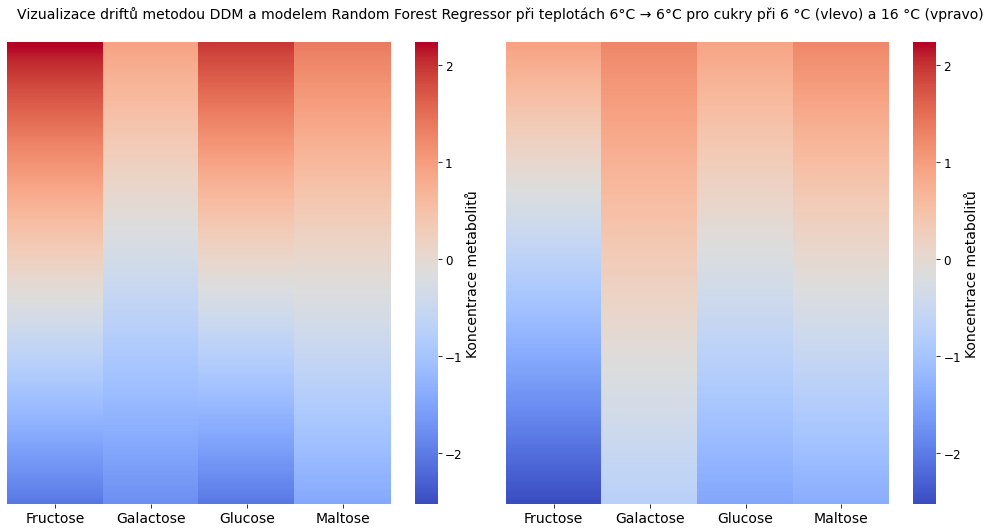

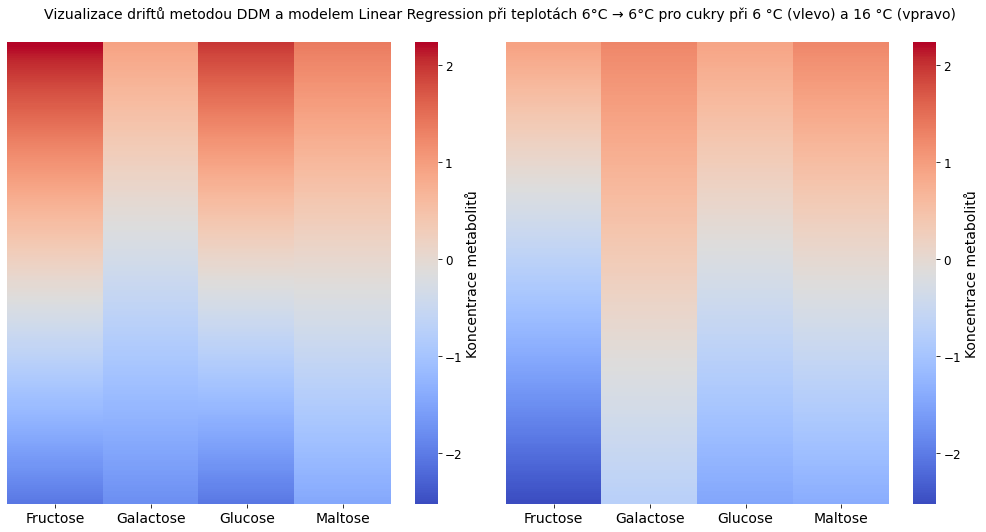

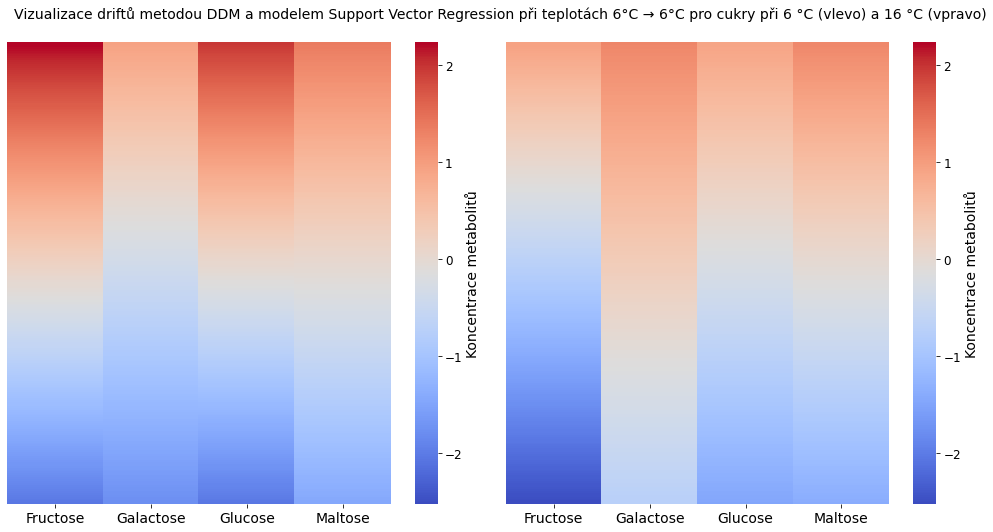

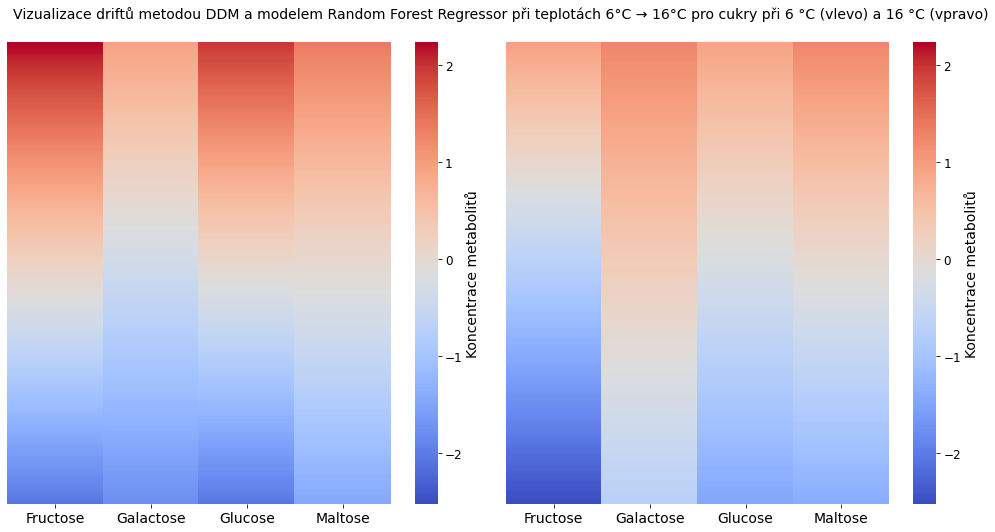

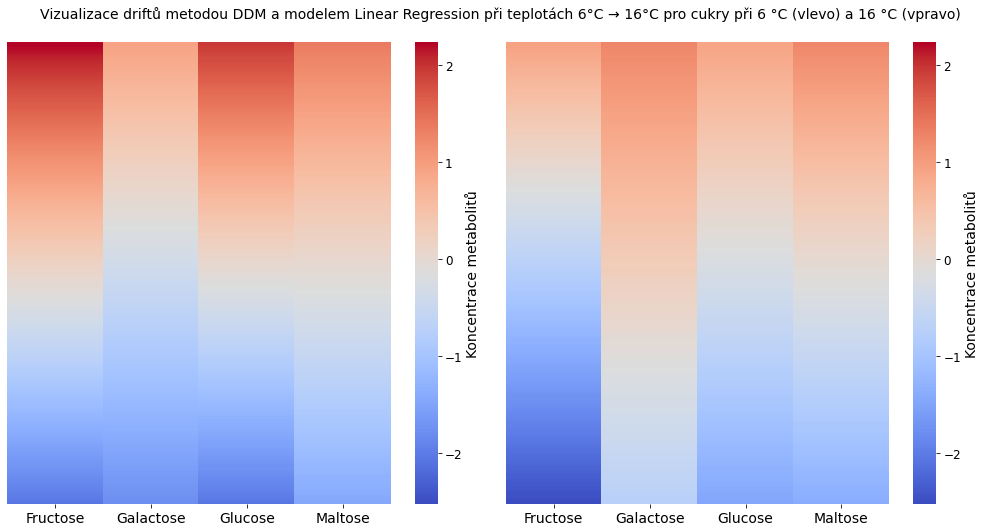

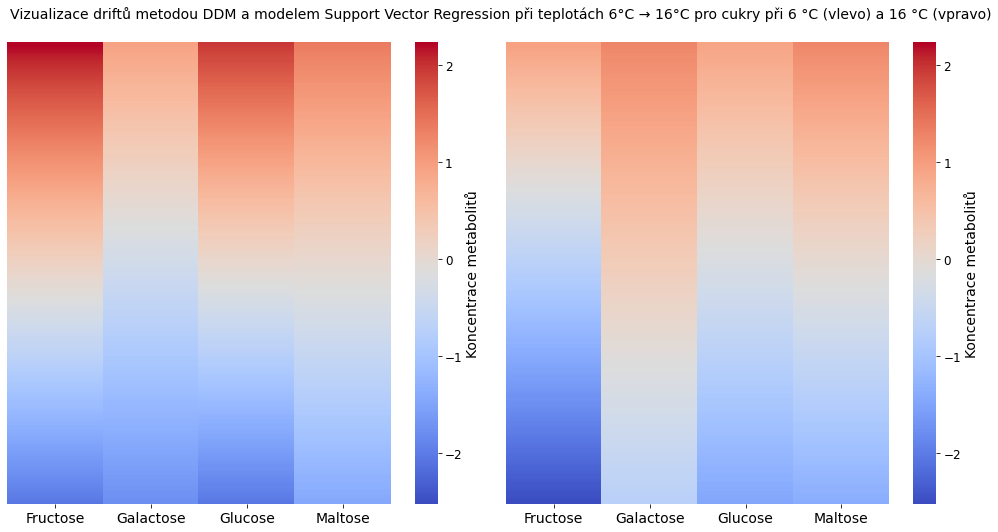

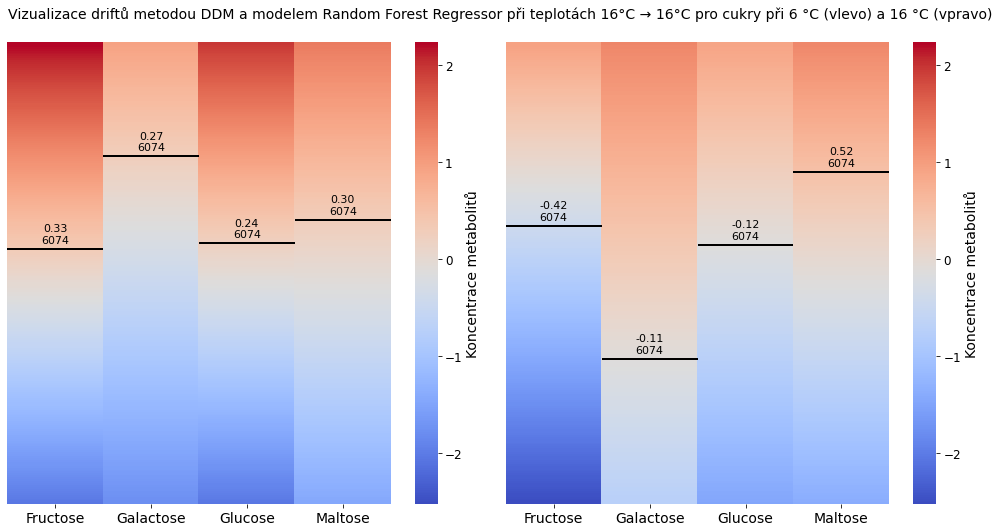

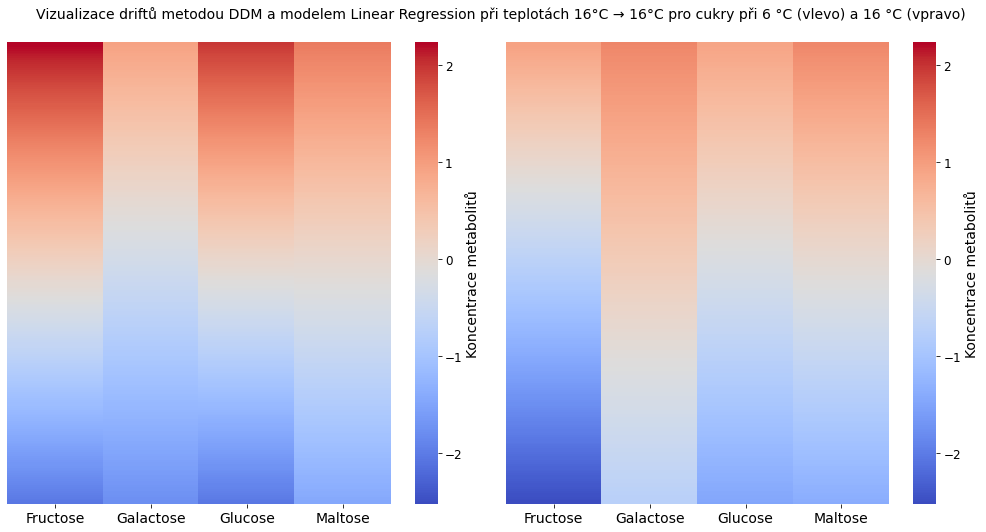

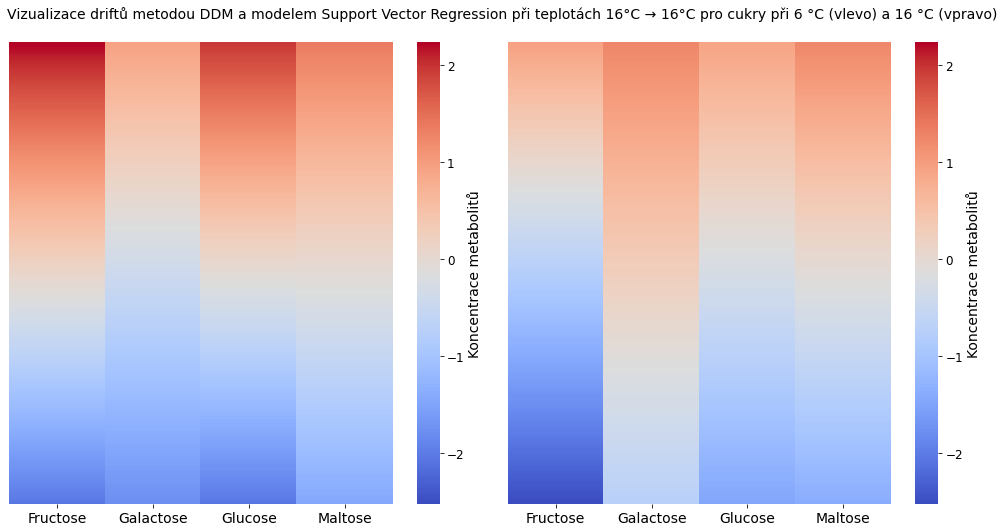

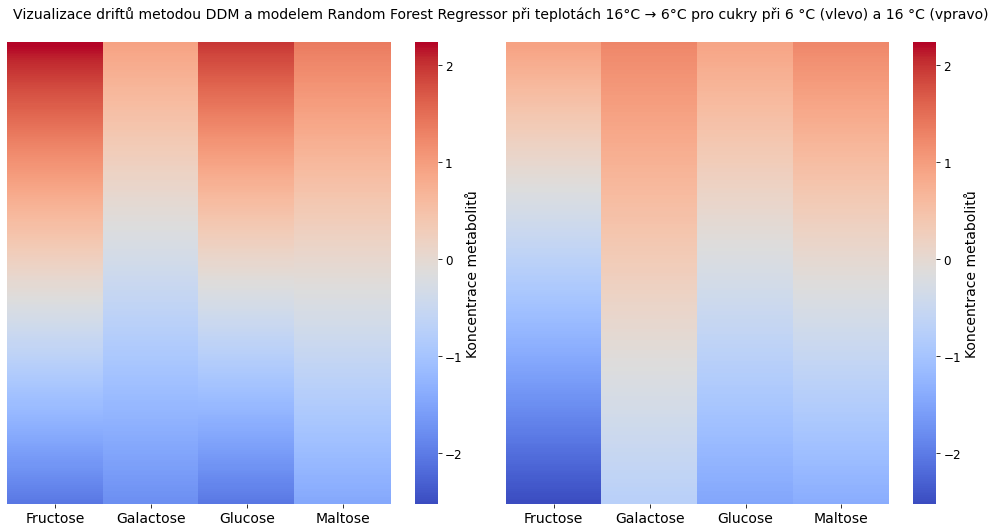

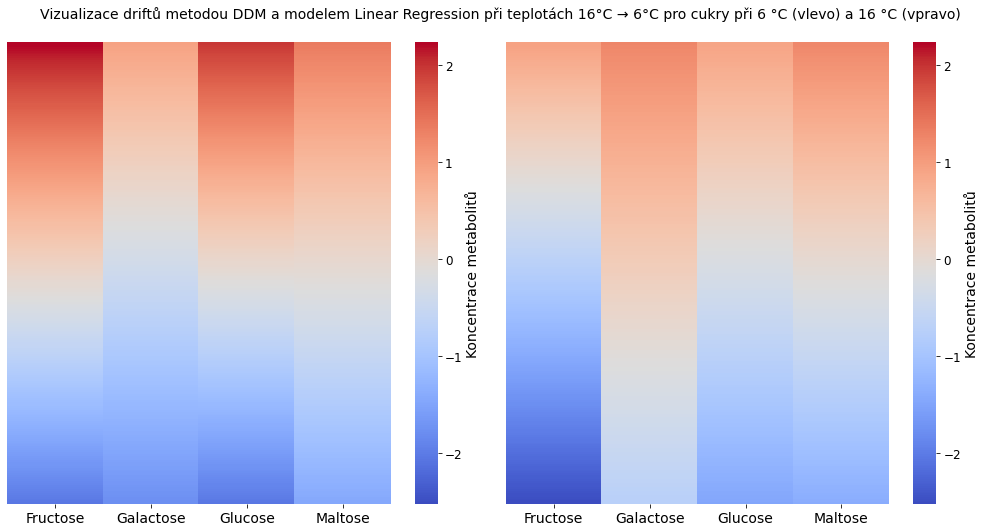

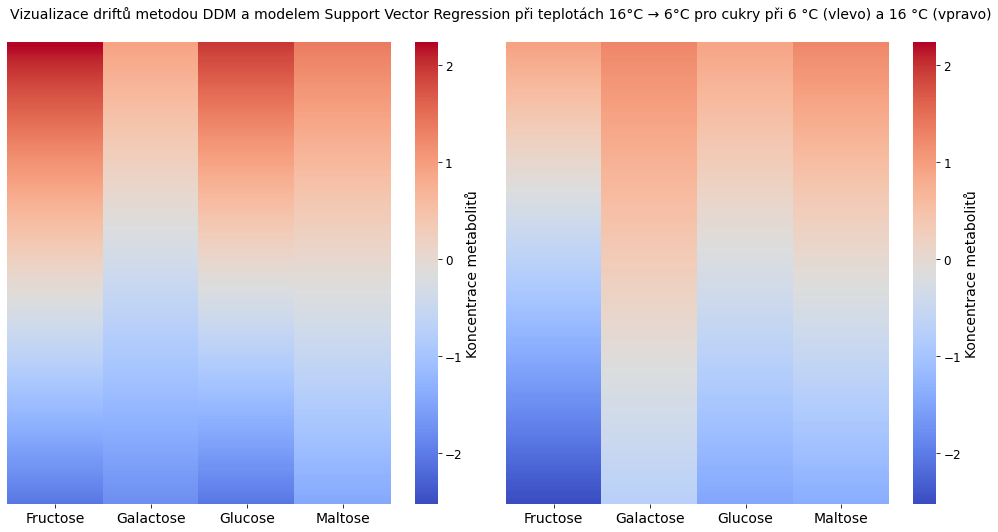

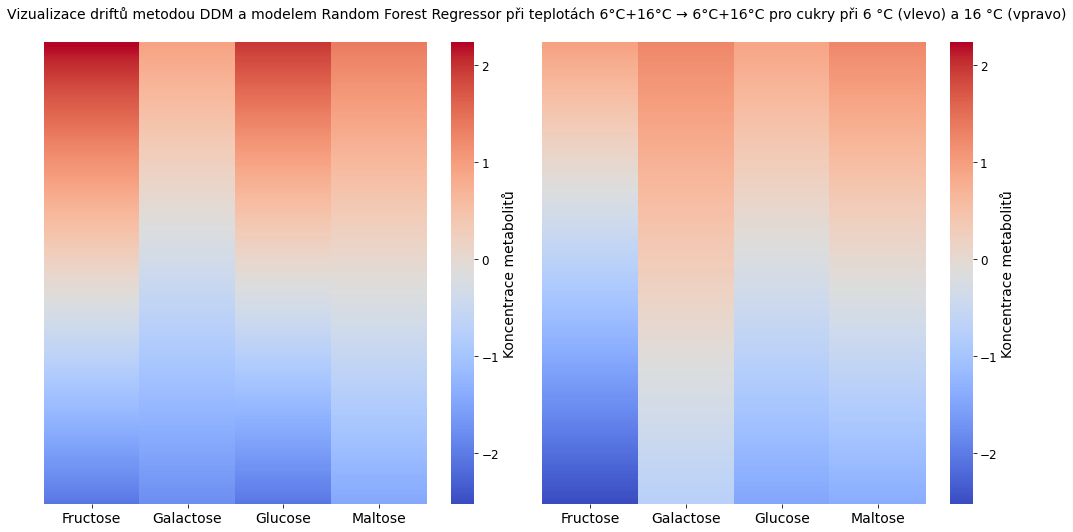

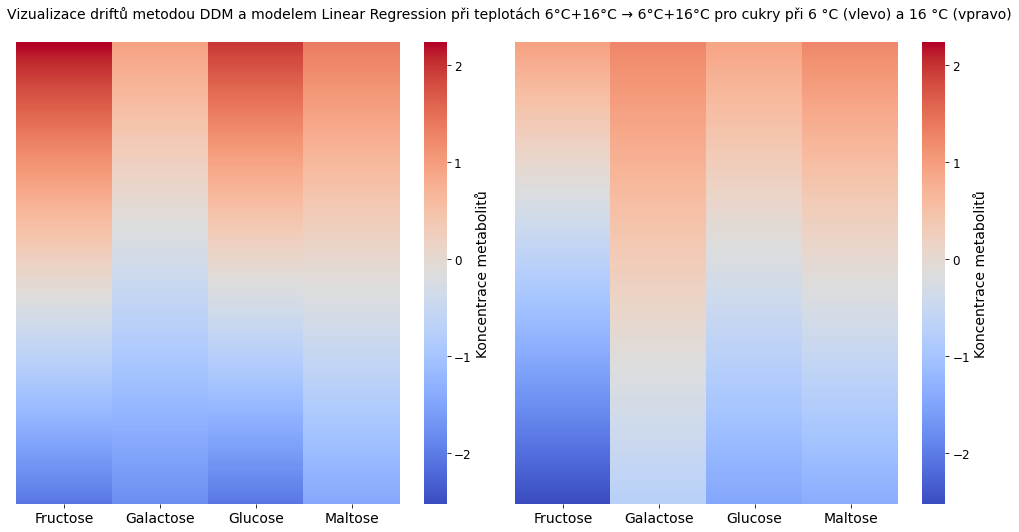

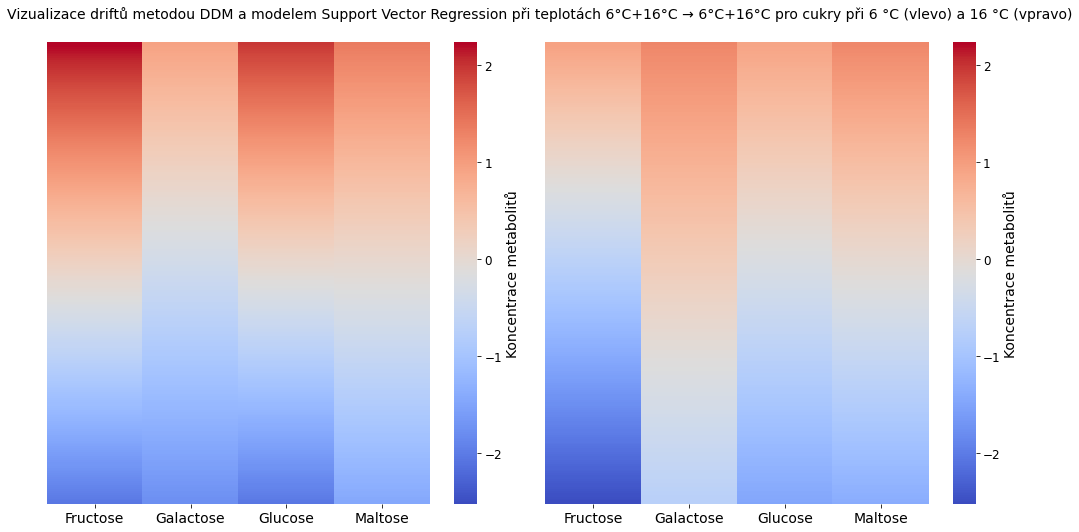

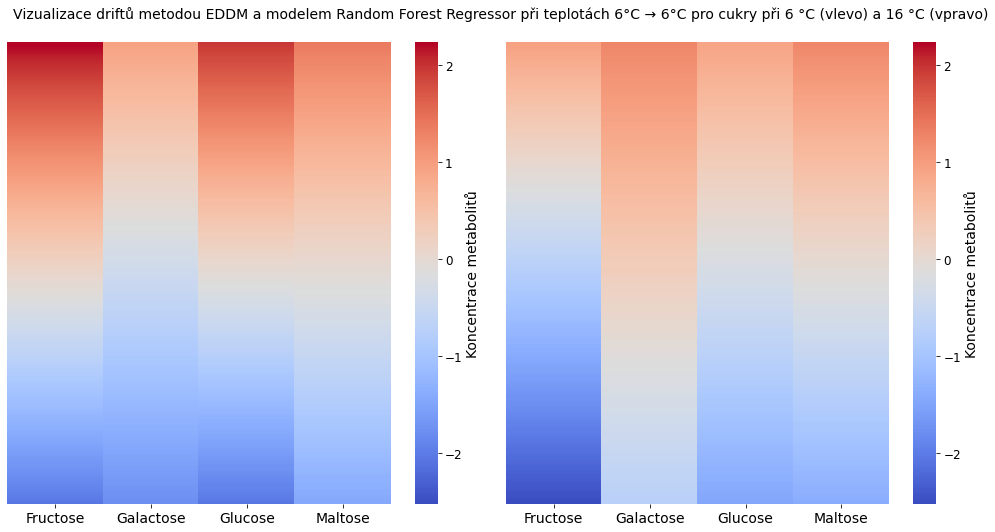

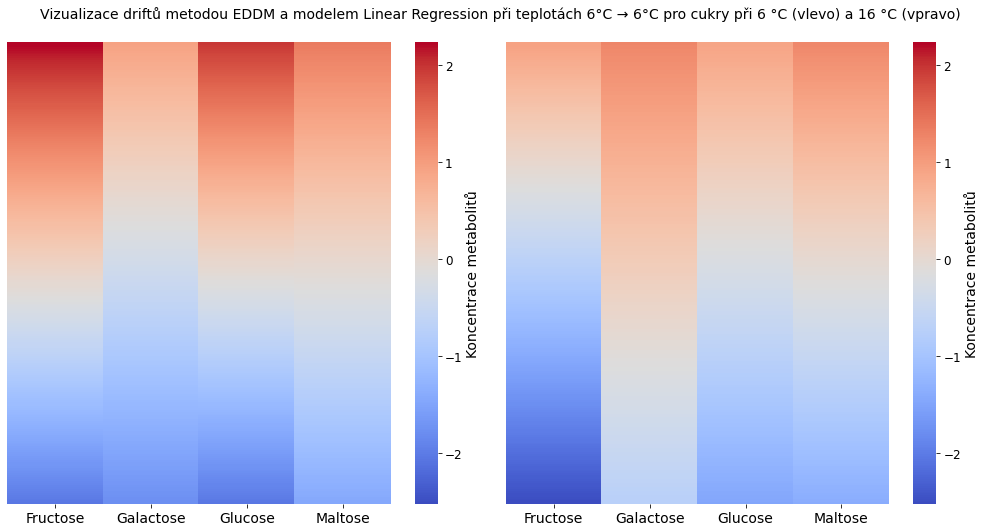

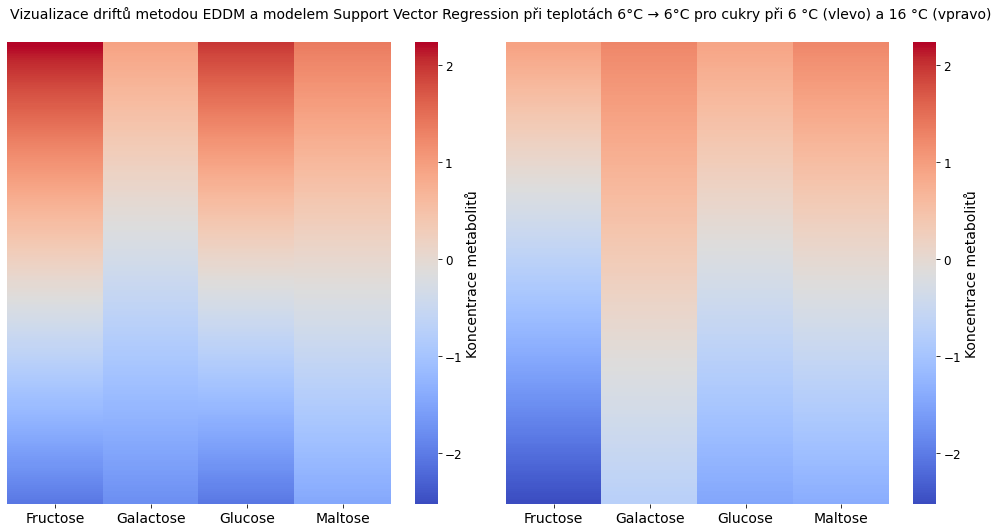

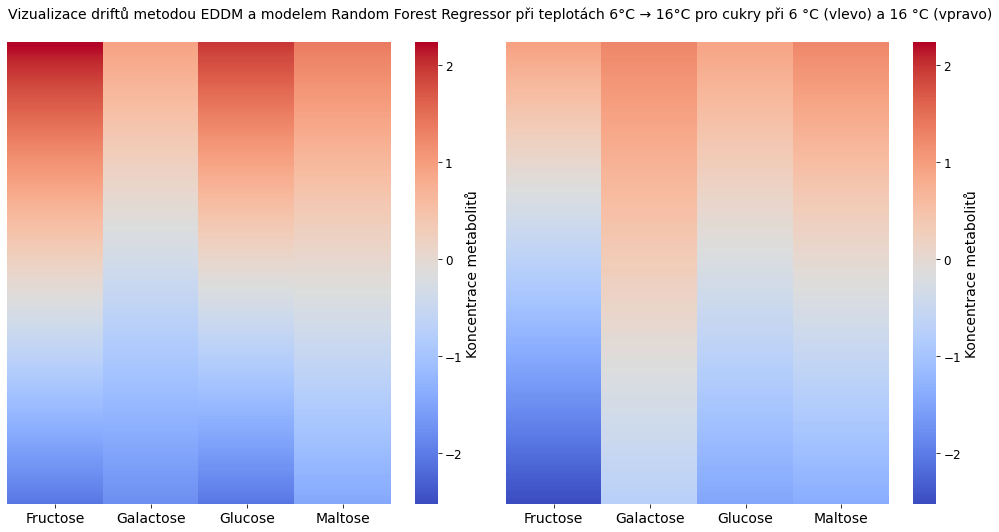

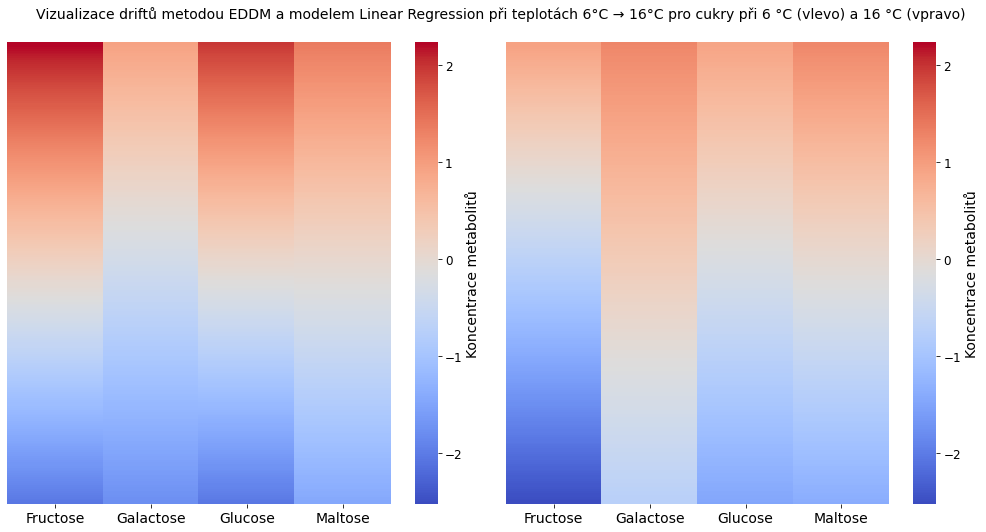

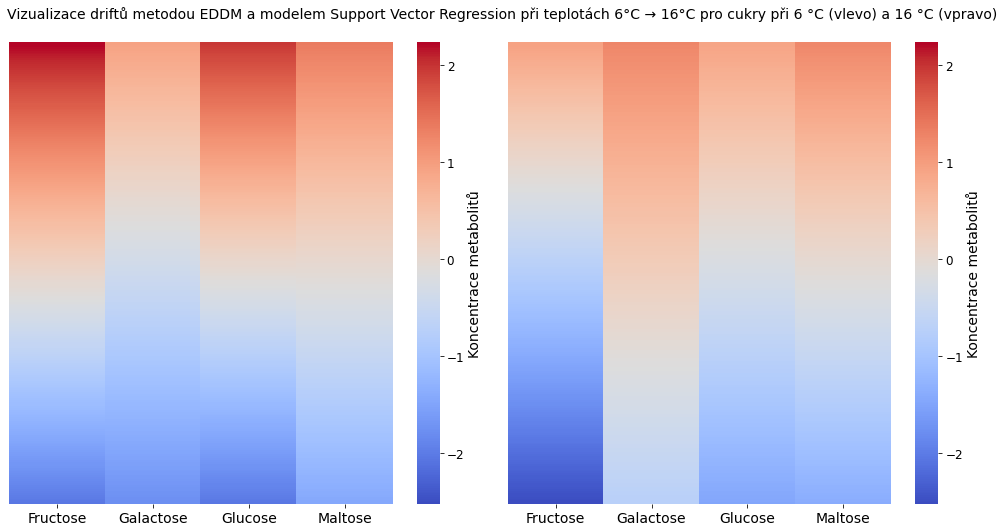

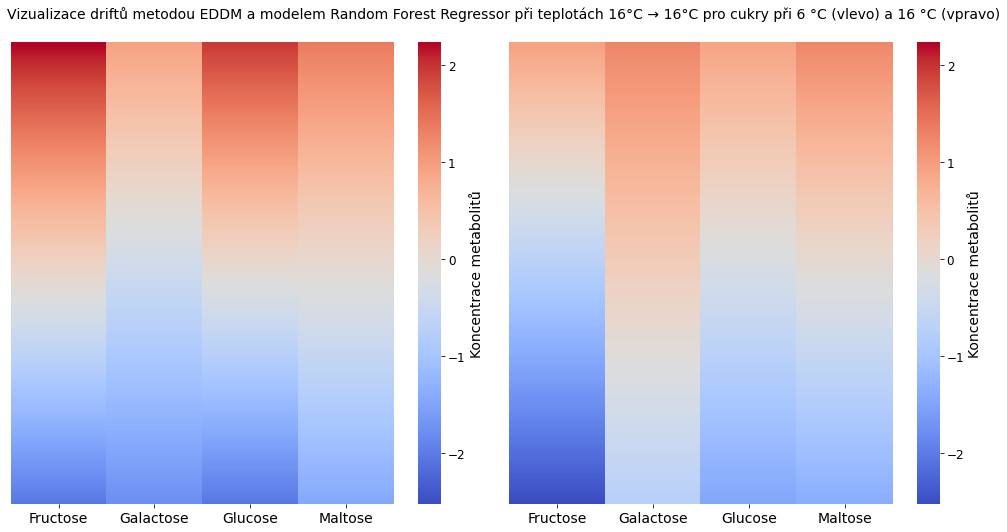

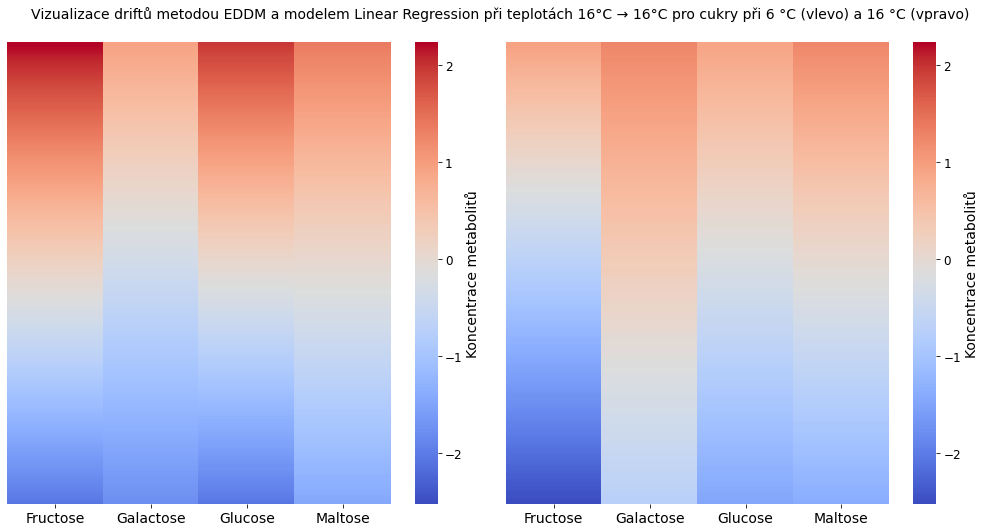

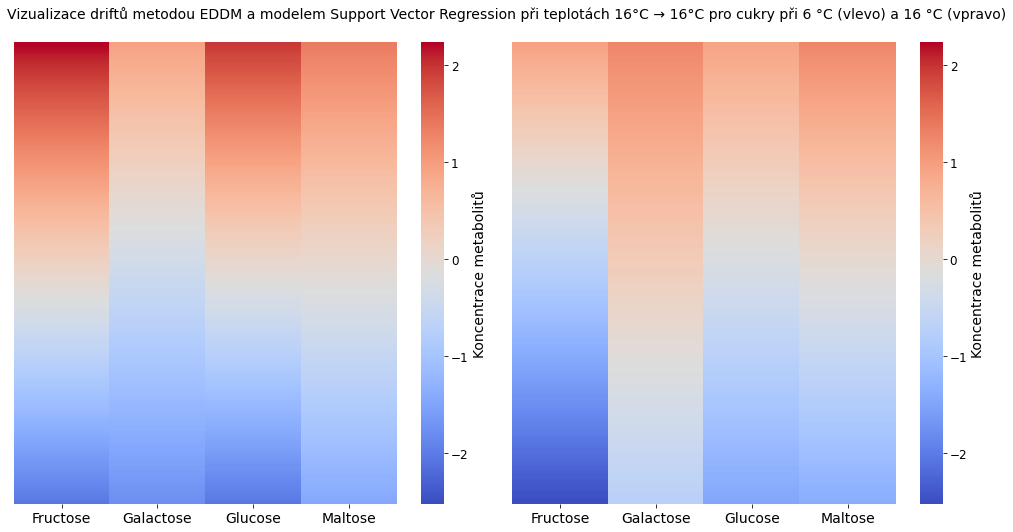

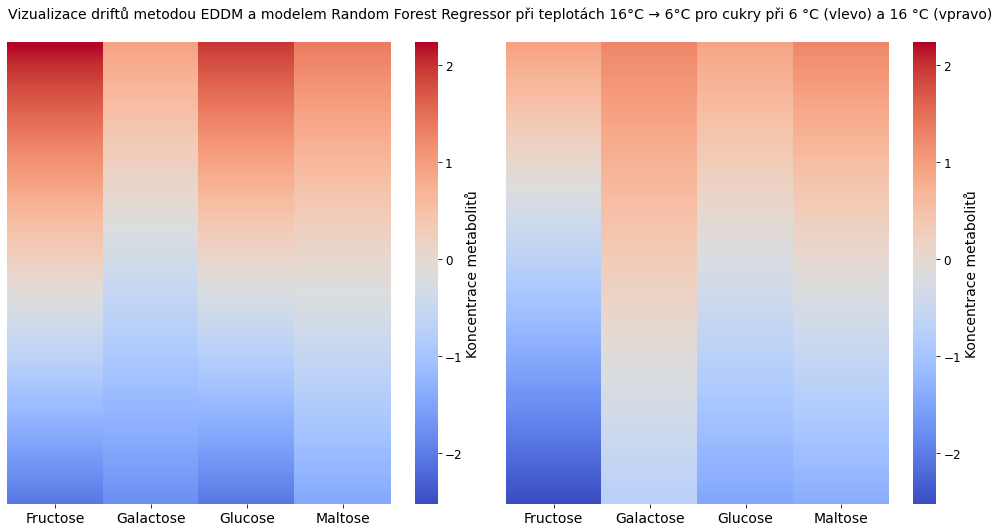

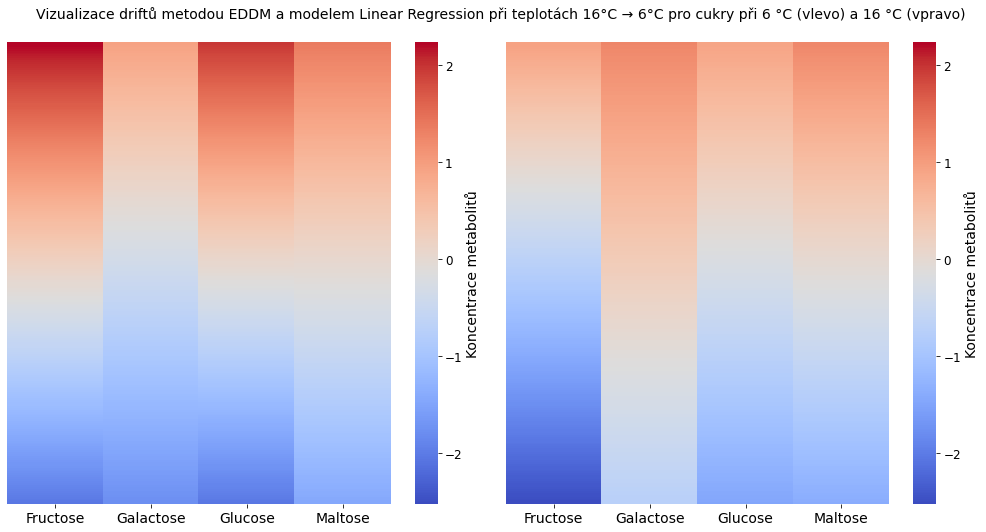

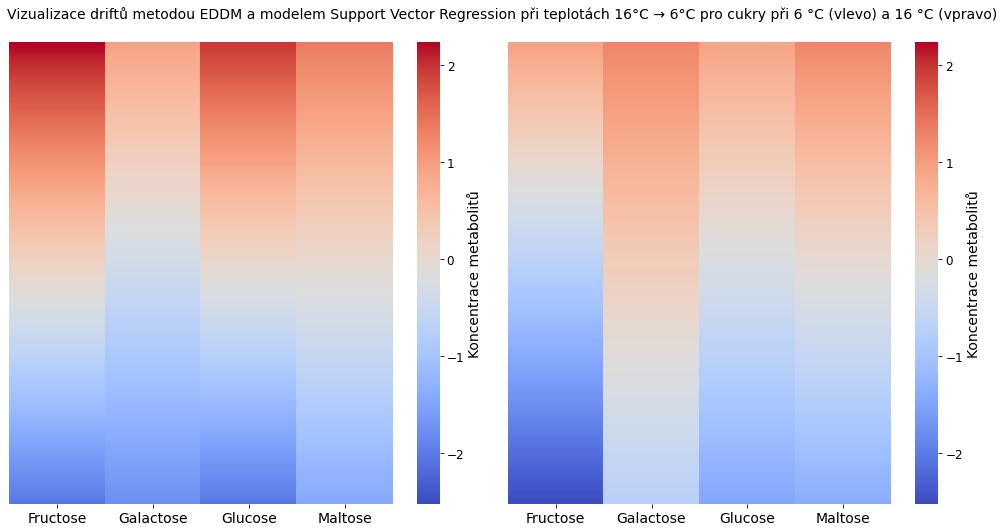

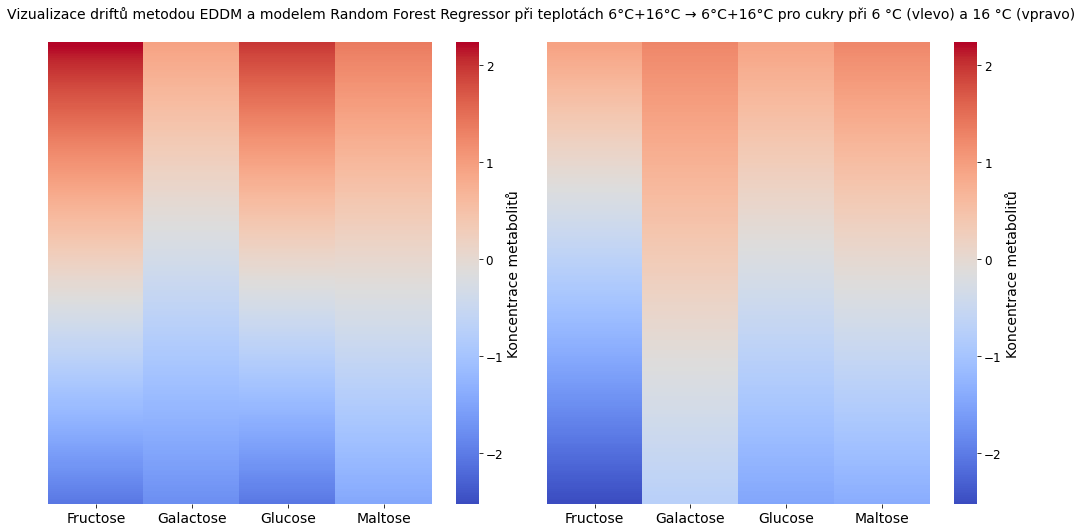

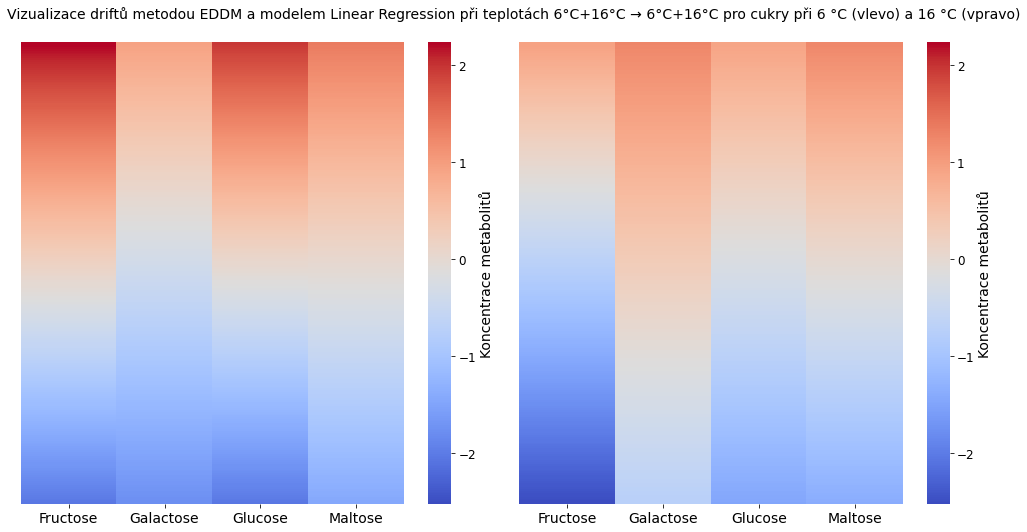

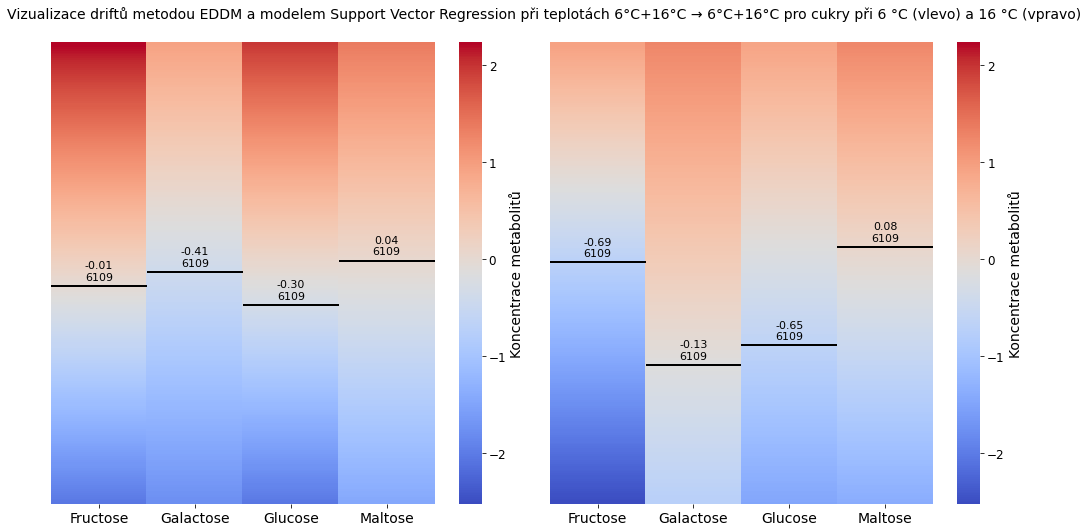

In [286]:
def heatmap_sugar_concentration(drift_indices, data_sugar_6, data_sugar_16, method, temperature, ecotypes):
    """
    Vykreslí heatmapy koncentrací cukrů při 6 °C a 16 °C
    a vyznačí detekované driftové body.

    Parametry:
    - drift_indices: dict, indexy driftů pro jednotlivé modely
    - data_sugar_6: np.ndarray, data koncentrací cukrů při 6 °C
    - data_sugar_16: np.ndarray, data koncentrací cukrů při 16 °C
    - method: str, název metody detekce driftu
    - temperature: str, popis teplotních podmínek
    - ecotypes: list, seznam ekotypů odpovídajících vzorkům
    """
    minimum_6 = np.min(data_sugar_6, axis=0)
    minimum_16 = np.min(data_sugar_16, axis=0)
    maximum_6 = np.max(data_sugar_6, axis=0)
    maximum_16 = np.max(data_sugar_16, axis=0)
    
    # Globální min a max pro škálování barevné mapy (společně pro obě teploty)
    min_global = min(np.min(minimum_6), np.min(minimum_16))
    max_global = max(np.max(maximum_6), np.max(maximum_16))
    
    # Vytvoříme prázdný seznam pro uchování výsledných vektorů
    list_of_linspaces_6 = []
    list_of_linspaces_16 = []
    
    for min_val, max_val in zip(minimum_6, maximum_6):
        list_of_linspaces_6.append(np.linspace(min_val, max_val, 239))

    # Převedení seznamu vektorů na numpy pole (2D matici)
    matrix_for_6 = np.array(list_of_linspaces_6)

    for min_val, max_val in zip(minimum_16, maximum_16):
        list_of_linspaces_16.append(np.linspace(min_val, max_val, 239))

   # Převedení seznamu vektorů na numpy pole (2D matici)
    matrix_for_16 = np.array(list_of_linspaces_16)

    # Pro každý model vykreslí heatmapu s označnými drifty    
    for name_model, drift_indice in drift_indices.items():
        
        plt.figure(figsize=(14, 7))
        
        # Heatmapa pro 6 °C - vlevo
        plt.subplot(1, 2, 1)
        ax1 = sns.heatmap(
            matrix_for_6.T,
            cmap='coolwarm',
            xticklabels=metabolites_sugar,
            yticklabels=False,
            cbar_kws={'label': 'Koncentrace metabolitů'},
            vmin=min_global,
            vmax=max_global
        )
        cbar1 = ax1.collections[0].colorbar
        cbar1.ax.yaxis.label.set_size(14)
        cbar1.ax.tick_params(labelsize=12)
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
        plt.gca().invert_yaxis()
        
        # Označení driftů na heatmapě pro 6 °C
        for idx, metabolite in enumerate(metabolites_sugar):
            for drift in drift_indice:
                concentration = data_sugar_6[drift][idx]
                y_position_6 = np.abs(np.linspace(minimum_6[idx], maximum_6[idx], 239) - concentration).argmin()
                ecotype_label = ecotypes[drift][3:]
                # Vykreslení čáru označující drift
                ax1.hlines(y=y_position_6, xmin=idx, xmax=idx + 1, color='black', linestyle='-', linewidth=2, zorder=10)        
                ax1.text(
                    x=idx + 0.5,
                    y=y_position_6+2,
                    s=f"{concentration:.2f}\n{ecotype_label}",
                    color='black',
                    fontsize=11,
                    ha='center',
                    va='bottom',
                    zorder=11
                )
                
        # Heatmapa pro 16 °C - vpravo      
        plt.subplot(1, 2, 2)
        ax2=sns.heatmap(
            matrix_for_16.T,
            cmap='coolwarm',
            xticklabels=metabolites_sugar,
            yticklabels=False,
            cbar_kws={'label': 'Koncentrace metabolitů'},
            vmin=min_global,
            vmax=max_global
        )
        cbar2 = ax2.collections[0].colorbar
        cbar2.ax.yaxis.label.set_size(14)
        cbar2.ax.tick_params(labelsize=12)
        ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=14)
        plt.gca().invert_yaxis()
        
        # Označení driftů na heatmapě pro 16 °C
        for idx, metabolite in enumerate(metabolites_sugar):
            for drift in drift_indice:
                concentration = data_sugar_16[drift][idx]
                y_position_16 = np.abs(np.linspace(minimum_16[idx], maximum_16[idx], 239) - concentration).argmin()
                ecotype_label = ecotypes[drift][3:]
                ax2.hlines(y=y_position_16, xmin=idx, xmax=idx + 1, color='black', linestyle='-', linewidth=2, zorder=10)        
                ax2.text(
                    x=idx + 0.5,
                    y=y_position_16+2,
                    s=f"{concentration:.2f}\n{ecotype_label}",
                    color='black',
                    fontsize=11,
                    ha='center',
                    va='bottom',
                    zorder=11
                )
        plt.suptitle(f"Vizualizace driftů metodou {method} a modelem {name_model} při teplotách {temperature} pro cukry při 6 °C (vlevo) a 16 °C (vpravo)",fontsize=14,y=1.05)
        plt.tight_layout()
        plt.show()

# Volání funkce
heatmap_ddm_6_6 = heatmap_sugar_concentration(
    drift_indices_ddm_6_6, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "6°C → 6°C",
    names_of_ecotypes
)
heatmap_ddm_6_16 = heatmap_sugar_concentration(
    drift_indices_ddm_6_16, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "6°C → 16°C",
    names_of_ecotypes
)
heatmap_ddm_16_16 = heatmap_sugar_concentration(
    drift_indices_ddm_16_16, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "16°C → 16°C",
    names_of_ecotypes
)
heatmap_ddm_16_6 = heatmap_sugar_concentration(
    drift_indices_ddm_16_6, 
    data_sugar_6, 
    data_sugar_16, 
    "DDM",
    "16°C → 6°C",
    names_of_ecotypes
)
heatmap_ddm_com = heatmap_sugar_concentration(
    drift_indices_ddm_com, 
    data_sugar_6, 
    data_sugar_16,
    "DDM",
    "6°C+16°C → 6°C+16°C",
    names_of_ecotypes
)
heatmap_eddm_6_6 = heatmap_sugar_concentration(
    drift_indices_eddm_6_6, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "6°C → 6°C",
    names_of_ecotypes
)
heatmap_eddm_6_16 = heatmap_sugar_concentration(
    drift_indices_eddm_6_16, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "6°C → 16°C",
    names_of_ecotypes
)
heatmap_eddm_16_16 = heatmap_sugar_concentration(
    drift_indices_eddm_16_16, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "16°C → 16°C",
    names_of_ecotypes
)
heatmap_eddm_16_6 = heatmap_sugar_concentration(
    drift_indices_eddm_16_6, 
    data_sugar_6, 
    data_sugar_16, 
    "EDDM",
    "16°C → 6°C",
    names_of_ecotypes
)
heatmap_eddm_com = heatmap_sugar_concentration(
    drift_indices_eddm_com, 
    data_sugar_6, 
    data_sugar_16,
    "EDDM",
    "6°C+16°C → 6°C+16°C",
    names_of_ecotypes
)

In [294]:
!git branch -M main
!git push -u origin main

To https://github.com/terezaluskova/Koncept_drift_A_thaliana.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/terezaluskova/Koncept_drift_A_thaliana.git'
hint: Updates were rejected because the remote contains work that you do not
hint: have locally. This is usually caused by another repository pushing to
hint: the same ref. If you want to integrate the remote changes, use
hint: 'git pull' before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


[master (root-commit) 12a201a] Concept_drift_A_thaliana.ipynb
 1 file changed, 1652 insertions(+)
 create mode 100644 Concept_drift_A_thaliana.ipynb
